In [1]:
# 使用するモデルのインポート
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
# その他のモジュールのインポート
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_predict, cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc,
                             confusion_matrix, ConfusionMatrixDisplay)
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform, randint, expon
import random

In [3]:
# ファイルの読み込み、データの格納・欠損値処理・確認
# file_path = "C:/Users/thisi/OneDrive/共有ファイル/リモートデスクトップ/ビニング処理_卒研A.csv"
# file_path = "E:/実験/実験結果/卒研B/データセット/2. 不要特徴量削除/2.不要特徴量削除後 分類テスト.csv"
# file_path = "C:/Users/81806/OneDrive/共有ファイル/リモートデスクトップ/データセット/2. 不要特徴量削除/2.不要特徴量削除後 分類テスト.csv"
# file_path =  "C:/Users/thisi/OneDrive/共有ファイル/リモートデスクトップ/vif_result.csv"
file_path =  "C:/Users/thisi/OneDrive/共有ファイル/卒研B/データ最終版/2. 最終ファイルVIF主成分分析後 (2値sddis追加).csv"
target_column = "SD_dis"
data = pd.read_csv(file_path)
data = data.drop(columns=["SD_con","Interest","Duration_of_first_Visit"])
data = data.fillna(data.mean())
data = data.loc[403:467,:]
data.info()
X = data.drop(columns=[target_column])
y = data[target_column]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 403 to 467
Data columns (total 46 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   SD_dis                                                   65 non-null     int64  
 1   readers'_vocabulary                                      65 non-null     float64
 2   Average_duration_of_fixations                            65 non-null     float64
 3   Minimum_duration_of_fixations                            65 non-null     float64
 4   Maximum_duration_of_fixations                            65 non-null     float64
 5   Number_of_fixations                                      65 non-null     float64
 6   Duration_of_first_fixation                               65 non-null     float64
 7   Average_pupil_diameter                                   65 non-null     float64
 8   Average_duration_of_Visit_per

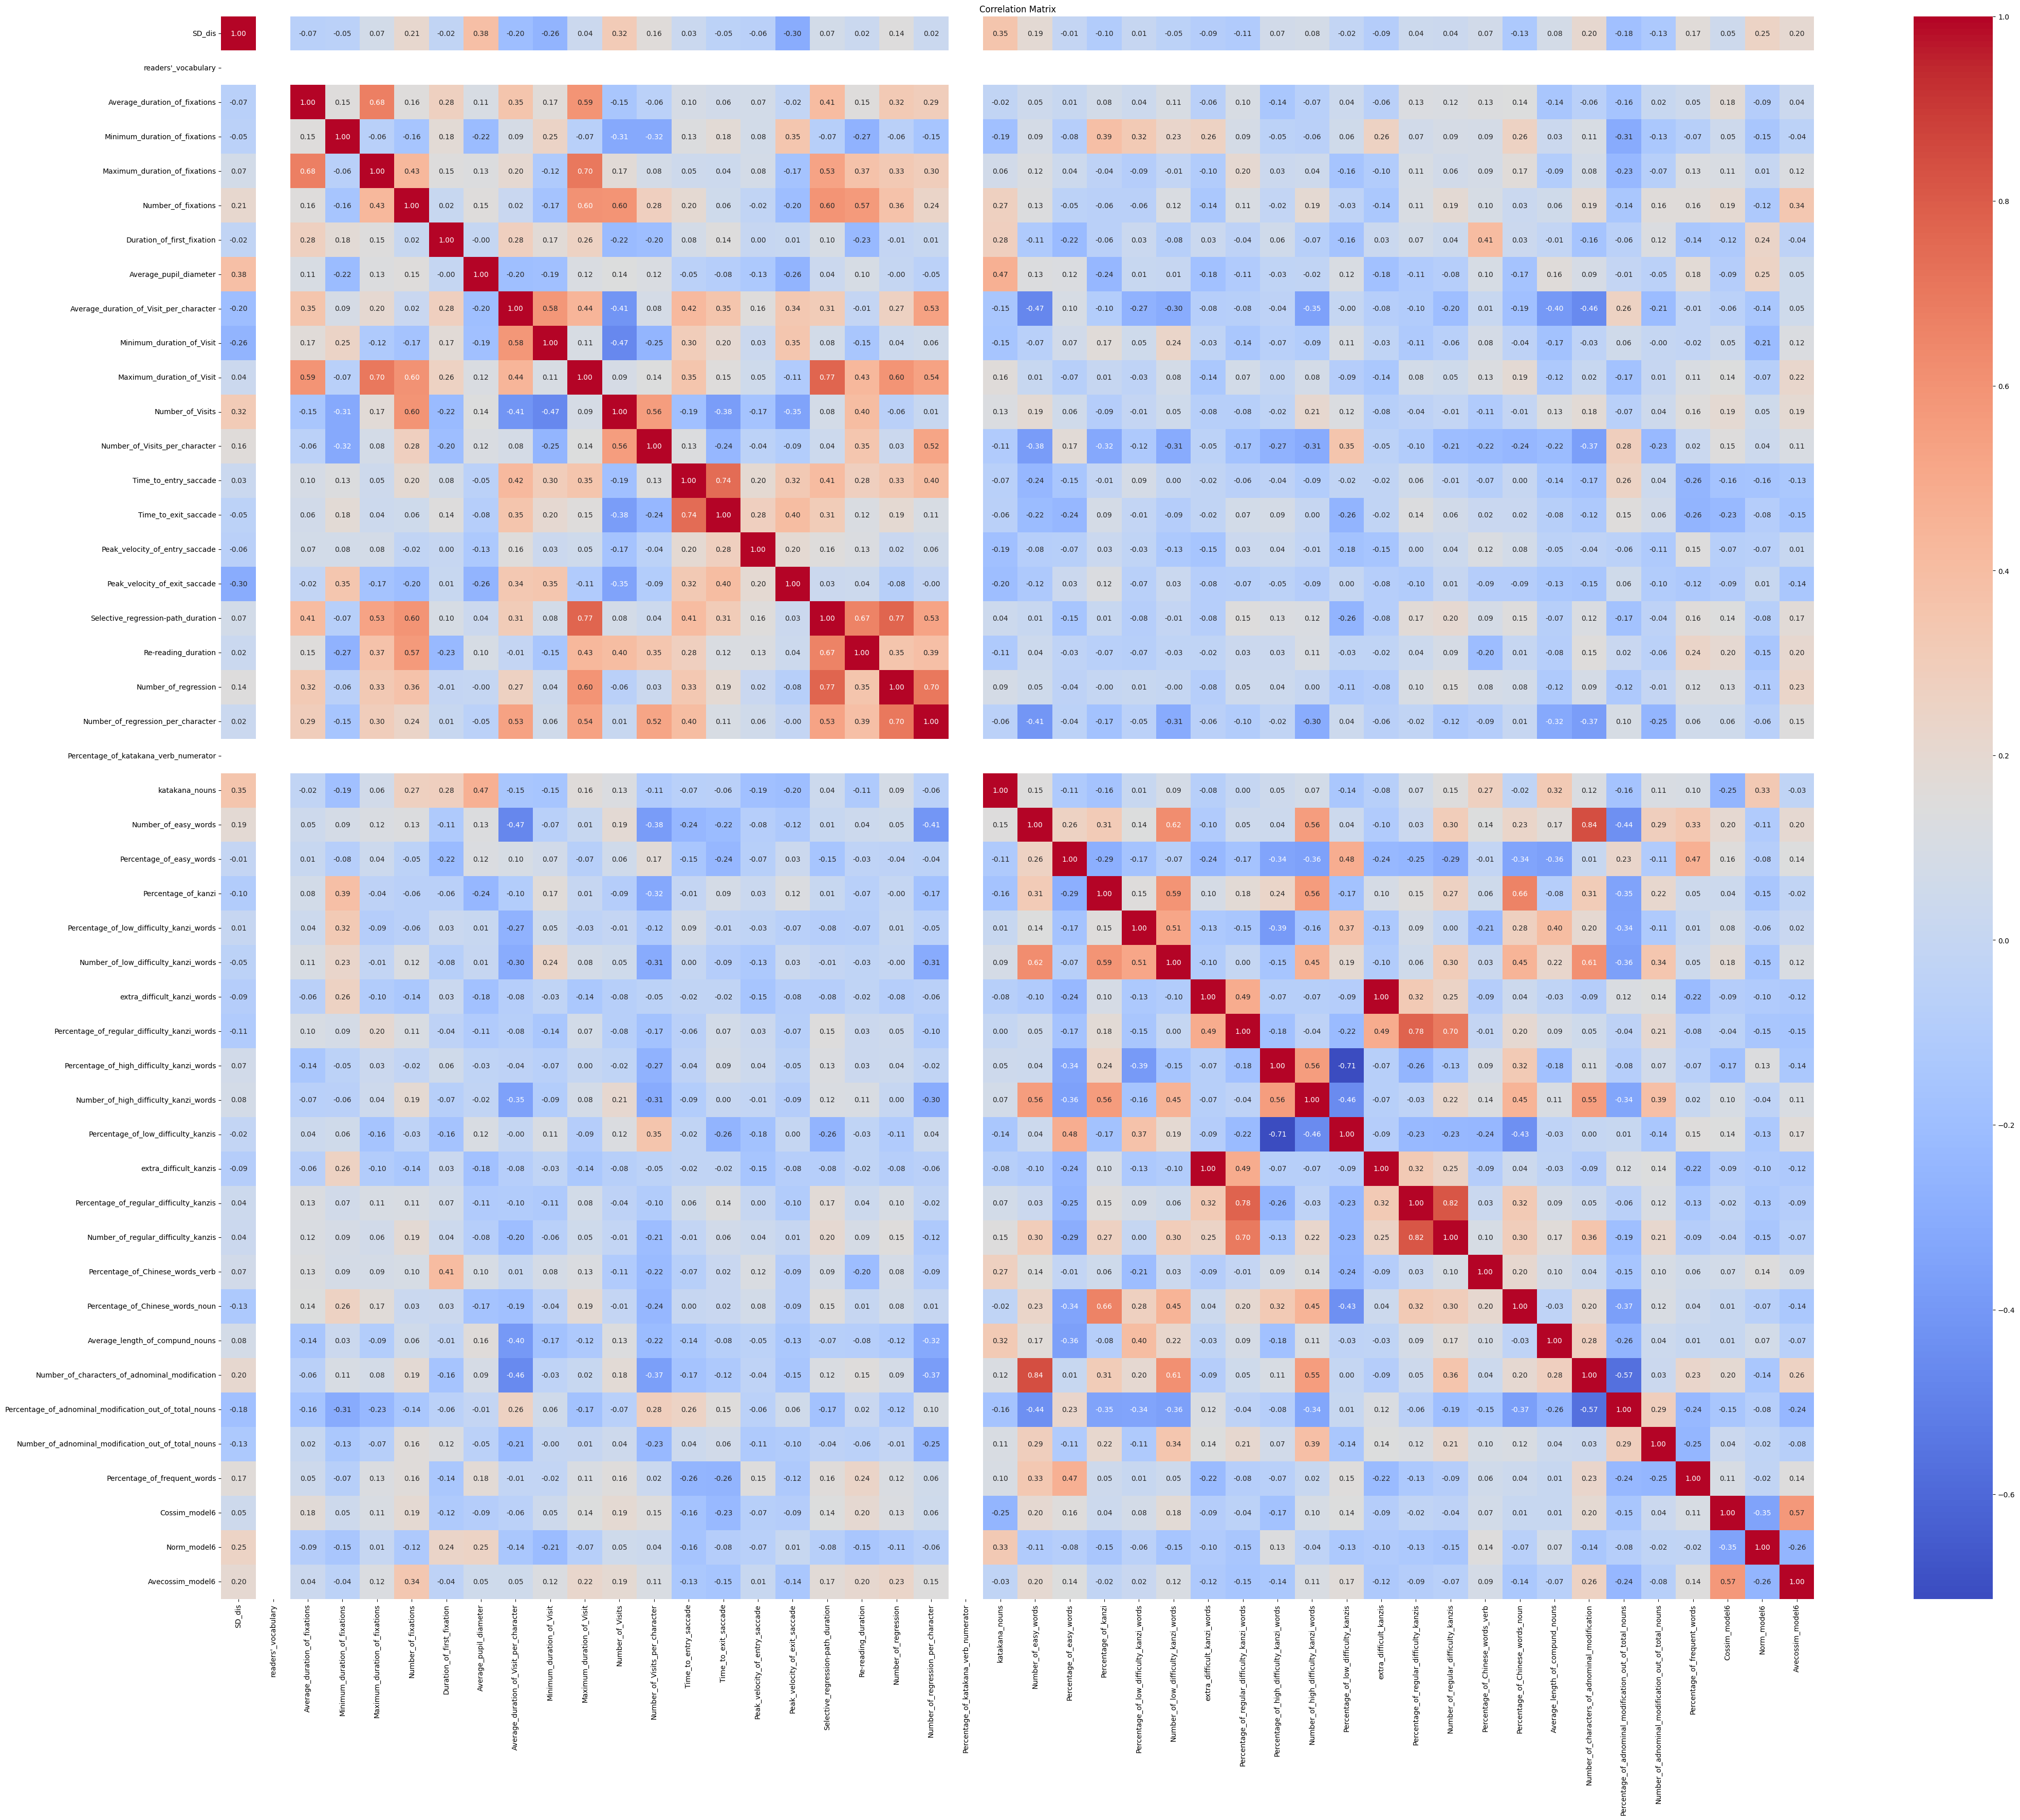

In [4]:
# データの可視化
plt.figure(figsize=(50, 40))
corr_matrix = data.corr('pearson')
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

# # データの可視化
# plt.figure(figsize=(50, 40))
# corr_matrix = data.corr('spearman')
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
# plt.title("Correlation Matrix")
# plt.show()

# # 散布図行列は時間かかるのでやりたいときだけ
# sns.pairplot(data)
# plt.title("Scatter Plot Matrix")
# plt.show()

In [5]:
# 特徴量選択
sfs = SFS(RandomForestClassifier(),
          k_features="best",
          forward = False,
          floating= True,
          scoring = 'accuracy',
          cv = 3,
          n_jobs= -1)

sfs = sfs.fit(X, y)

# 選択された特徴量の表示
selected_features = sfs.k_feature_names_
selected_features

('Average_duration_of_fixations',
 'Number_of_fixations',
 'Peak_velocity_of_exit_saccade',
 'Norm_model6',
 'Avecossim_model6')

In [6]:
# specific_feature = ['Maximum_duration_of_Visit',
#  'Number_of_Visits_per_character',
#  'Time_to_entry_saccade',
#  'Number_of_regression',
#  'extra_difficult_kanzi_words',
#  'Percentage_of_regular_difficulty_kanzi_words',
#  'Percentage_of_adnominal_modification_out_of_total_nouns',
#  'Cossim_model6',
#  'Norm_model6']

# sfs = "None"

# type(specific_feature)

In [7]:
# selected_features = X.columns #全特徴量のとき
# selected_features = specific_feature　#特徴量指定したいとき

# 選択された特徴量のみをXに指定
X_slected = X[list(selected_features)]
X_slected.head()

,Average_duration_of_fixations,Number_of_fixations,Peak_velocity_of_exit_saccade,Norm_model6,Avecossim_model6
403,0.003197,0.051737,2.147689,-0.355173,0.336233
404,-0.318657,0.969364,-1.155385,0.118052,0.582601
405,0.369445,-0.254138,-0.765130,0.315171,0.497867
406,0.924366,2.131691,-0.805832,-0.013671,0.370102
407,-0.085590,2.865793,0.830972,-0.149397,-0.046301


In [8]:
# 選択された特徴量でモデル構築
X_train, X_test, y_train, y_test = train_test_split(X_slected, y, test_size=0.2, random_state=42, stratify=y)

# 標準化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
# Define StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [10]:

# モデルの構築
base_models = [
        ('log', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('gb', GradientBoostingClassifier(random_state=42)),
        ('svm', svm.SVC(kernel='rbf', probability=True, random_state=42)),
        ('knn', KNeighborsClassifier()),
        ('mlp', MLPClassifier(random_state=42)),
        ('nb', GaussianNB())
    ]

param_dist = {
    'log__penalty': ["l2"],
    'log__C': randint(1, 3),
    'log__solver': ['lbfgs', 'sag', 'liblinear'],
    'log__max_iter': randint(50, 150),
    'rf__n_estimators': randint(50, 150),
    'rf__criterion': ['gini', 'entropy', 'log_loss'],
    'rf__max_depth': randint(5, 50),
    'rf__min_samples_split': randint(1, 3),
    'rf__min_samples_leaf': uniform(0.01, 1),
    'gb__n_estimators':randint(80, 200),
    'gb__learning_rate': uniform(0.01, 0.3),
    'gb__max_depth':randint(3, 10),
    'gb__min_samples_leaf':randint(1, 5),
    'gb__subsample':uniform(0.5, 1.0),
    'svm__C': uniform(0.01, 100),
    'svm__gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'knn__n_neighbors':randint(2, 7),
    'knn__leaf_size':randint(10, 50),
    'mlp__hidden_layer_sizes': [(100,), (50,), (100, 50)],
    'mlp__alpha': uniform(0.0001, 0.01),
    'mlp__max_iter': randint(100, 300),
    'nb__var_smoothing': [1e-9, 5e-9, 1e-8],
    'final_estimator__C' : randint(1, 3),
    'final_estimator__max_iter' : randint(50, 150),
    'final_estimator__penalty' : ["l2"],
    'final_estimator__solver' : ['lbfgs', 'sag', 'liblinear']
}

meta_model = LogisticRegression(random_state=42)

stacking_model = StackingClassifier(estimators=base_models,
                                     final_estimator=meta_model,
                                       cv=3)


In [11]:
# ランダムサーチの実行
random_search = RandomizedSearchCV(estimator=stacking_model,
                                   param_distributions=param_dist,
                                   n_iter=300,
                                   cv=3,
                                   scoring='accuracy',
                                   random_state=42)

random_search.fit(X_train_scaled, y_train)
print(random_search.best_params_)

c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (249) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (249) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (249) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (249) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\neural_netw

{'final_estimator__C': 2, 'final_estimator__max_iter': 101, 'final_estimator__penalty': 'l2', 'final_estimator__solver': 'lbfgs', 'gb__learning_rate': 0.1443020276231255, 'gb__max_depth': 8, 'gb__min_samples_leaf': 1, 'gb__n_estimators': 129, 'gb__subsample': 0.8019167000775018, 'knn__leaf_size': 43, 'knn__n_neighbors': 6, 'log__C': 2, 'log__max_iter': 70, 'log__penalty': 'l2', 'log__solver': 'sag', 'mlp__alpha': 0.0008623921797356448, 'mlp__hidden_layer_sizes': (50,), 'mlp__max_iter': 161, 'nb__var_smoothing': 5e-09, 'rf__criterion': 'entropy', 'rf__max_depth': 22, 'rf__min_samples_leaf': 0.5568596409751262, 'rf__min_samples_split': 2, 'rf__n_estimators': 62, 'svm__C': 45.869794351383995, 'svm__gamma': 0.01}


c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (161) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (161) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (161) reached and the optimization hasn't converged yet.
  warnings.warn(


In [12]:
# 最終モデルの構築
final_model = random_search.best_estimator_
final_model.fit(X_train_scaled, y_train)

c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (161) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (161) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (161) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (161) reached and the optimization hasn't converged yet.
  warnings.warn(


StackingClassifier(cv=3,
                   estimators=[('log',
                                LogisticRegression(C=2, max_iter=70,
                                                   random_state=42,
                                                   solver='sag')),
                               ('rf',
                                RandomForestClassifier(criterion='entropy',
                                                       max_depth=22,
                                                       min_samples_leaf=0.5568596409751262,
                                                       n_estimators=62,
                                                       random_state=42)),
                               ('gb',
                                GradientBoostingClassifier(learning_rate=0.1443020276231255,
                                                           max_depth=8,
                                                           n_estimators=129,
                                                           random_state=42,
                                                           subsample=0.8019167000775018)),
                               ('svm',
                                SVC(C=45.869794351383995, gamma=0.01,
                                    probability=True, random_state=42)),
                               ('knn',
                                KNeighborsClassifier(leaf_size=43,
                                                     n_neighbors=6)),
                               ('mlp',
                                MLPClassifier(alpha=0.0008623921797356448,
                                              hidden_layer_sizes=(50,),
                                              max_iter=161, random_state=42)),
                               ('nb', GaussianNB(var_smoothing=5e-09))],
                   final_estimator=LogisticRegression(C=2, max_iter=101,
                                                      random_state=42))

Accuracy: 0.7692307692307693
Precision: 0.758974358974359
Recall: 0.7692307692307693
F1 Score: 0.7588201272411799


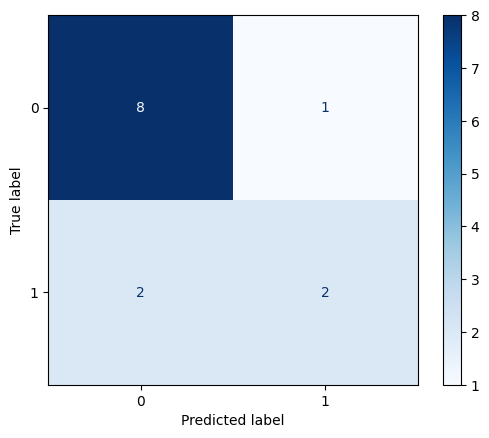

In [13]:
# 最終モデルのテストデータへの適用および性能評価
y_pred = final_model.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap='Blues')
plt.show()

In [14]:
print("ROC:",roc_auc_score(y_test, y_pred))

ROC: 0.6944444444444444


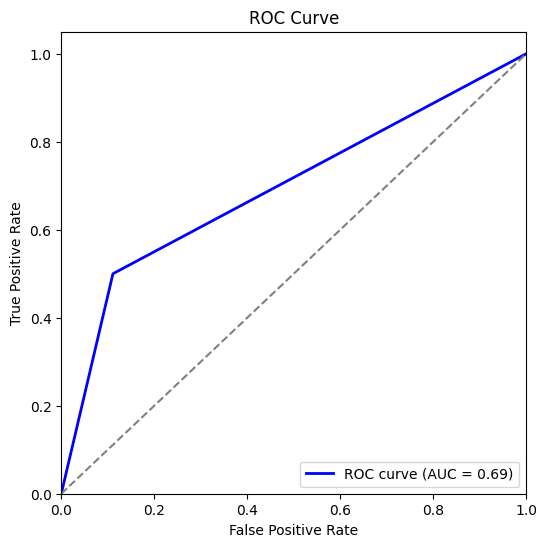

In [15]:
# Compute ROC curve and AUC score
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [16]:
cv_clf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Compare base models
Model_accuracy = {}
for name, model in random_search.best_estimator_.estimators:
    scores = cross_val_score(model, X, y, cv=cv_clf, scoring='accuracy')
    Model_accuracy[f"{name}"] = scores.mean()
    print(f"{name} Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")

# Evaluate stacking model
stacking_scores = cross_val_score(final_model, X, y, cv=cv_clf, scoring='accuracy')
print(f"Stacking Model Accuracy: {stacking_scores.mean():.4f} (+/- {stacking_scores.std():.4f})")

c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


log Accuracy: 0.6000 (+/- 0.2143)
rf Accuracy: 0.6769 (+/- 0.0308)
gb Accuracy: 0.6923 (+/- 0.1614)
svm Accuracy: 0.6000 (+/- 0.2087)
knn Accuracy: 0.6462 (+/- 0.1043)


c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (161) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (161) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (161) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (161) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\neural_netw

mlp Accuracy: 0.6154 (+/- 0.1287)
nb Accuracy: 0.4923 (+/- 0.1043)


c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (161) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (161) reached and the optimization hasn't converged yet.
  warning

Stacking Model Accuracy: 0.6769 (+/- 0.1231)


c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (161) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (161) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (161) reached and the optimization hasn't converged yet.
  warnings.warn(


In [17]:
# 各モデルの特徴量重要度をPFIとSHAPで算出
from sklearn.inspection import permutation_importance
import shap

# 訓練データ(X_train, y_train)を用いてモデルをフィットします
for name, model in random_search.best_estimator_.estimators:
    model.fit(X_train, y_train)


c:\WorkSpace\Practice\env3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (161) reached and the optimization hasn't converged yet.
  warnings.warn(


In [18]:

PFIs = {}
for name, model in random_search.best_estimator_.estimators:
    pfi = permutation_importance(model, X_train, y_train, random_state=42)
    # 特徴量の名前と重要度をセットにした辞書を作成
    feature_importances = {X_train.columns[i]: pfi.importances_mean[i] for i in range(len(X_train.columns))}
    PFIs[f'{name}'] = feature_importances

# 結果の確認
for model_name, importances in PFIs.items():
    print(f"Model: {model_name}")
    for feature, importance in importances.items():
        print(f"  {feature}: {importance:.4f}")


Model: log
  Average_duration_of_fixations: 0.0231
  Number_of_fixations: 0.0577
  Peak_velocity_of_exit_saccade: 0.0308
  Norm_model6: 0.1115
  Avecossim_model6: 0.0308
Model: rf
  Average_duration_of_fixations: 0.0000
  Number_of_fixations: 0.0000
  Peak_velocity_of_exit_saccade: 0.0000
  Norm_model6: 0.0000
  Avecossim_model6: 0.0000
Model: gb
  Average_duration_of_fixations: 0.0308
  Number_of_fixations: 0.0769
  Peak_velocity_of_exit_saccade: 0.1769
  Norm_model6: 0.0500
  Avecossim_model6: 0.0192
Model: svm
  Average_duration_of_fixations: 0.0154
  Number_of_fixations: 0.0692
  Peak_velocity_of_exit_saccade: 0.0577
  Norm_model6: 0.1192
  Avecossim_model6: 0.0115
Model: knn
  Average_duration_of_fixations: 0.0077
  Number_of_fixations: 0.0231
  Peak_velocity_of_exit_saccade: 0.0231
  Norm_model6: 0.0692
  Avecossim_model6: -0.0000
Model: mlp
  Average_duration_of_fixations: 0.0346
  Number_of_fixations: 0.1077
  Peak_velocity_of_exit_saccade: 0.0769
  Norm_model6: 0.1077
  Avecos

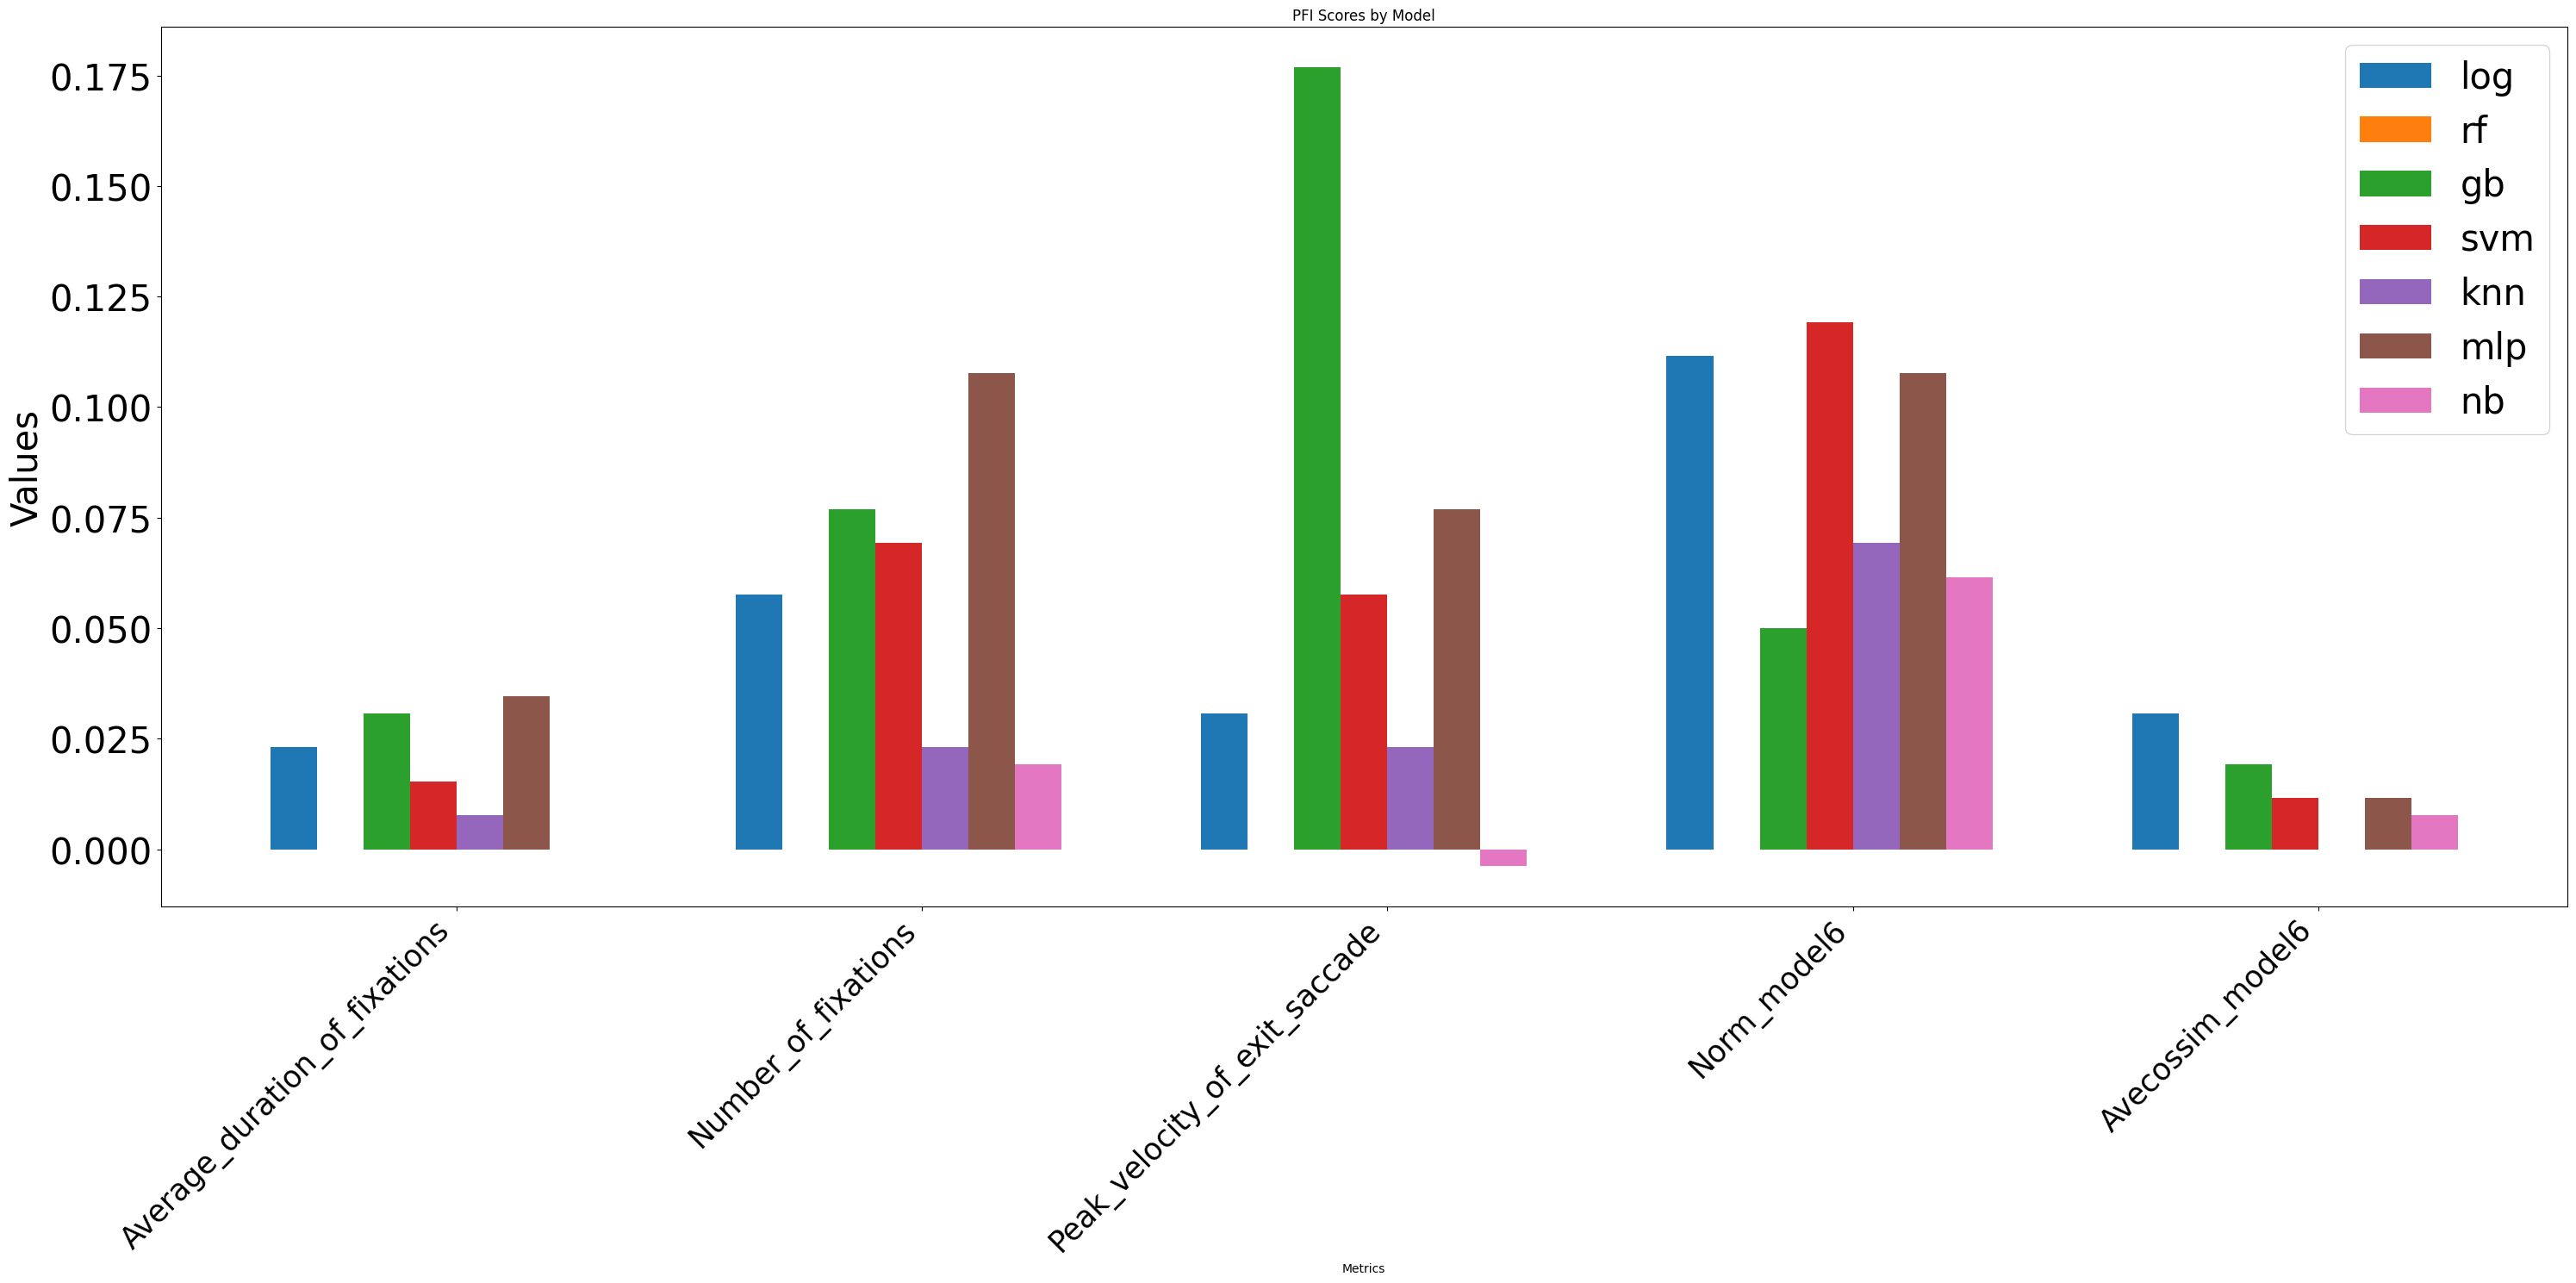

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# 指標のリスト（全モデル共通）
metrics = list(PFIs["log"].keys())
num_metrics = len(metrics)
num_models = len(PFIs.keys())

# グラフの準備
x = np.arange(num_metrics)  # X軸の位置
width = 0.1  # バーの幅

fig, ax = plt.subplots(figsize=(30, 15))

# 各モデルごとにバーを描画
for i, (model, values) in enumerate(PFIs.items()):
    ax.bar(x + i * width, values.values(), width, label=model)

# 軸ラベルと凡例
ax.set_xlabel("Metrics")
ax.set_ylabel("Values", fontsize=30)
ax.set_title("PFI Scores by Model")
ax.set_xticks(x + width * (num_models / 2))
# ax.set_yticklabels(values, fontsize=30)
ax.tick_params(axis='y', labelsize=30)
ax.set_xticklabels(metrics, rotation=45, ha="right", fontsize=25)
ax.legend(fontsize=30, loc='best')

plt.tight_layout()
plt.show()


100%|██████████| 52/52 [00:00<00:00, 74.64it/s]


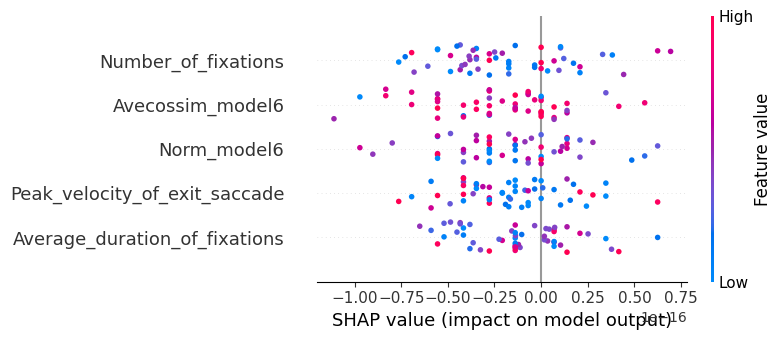

100%|██████████| 52/52 [00:01<00:00, 49.17it/s]


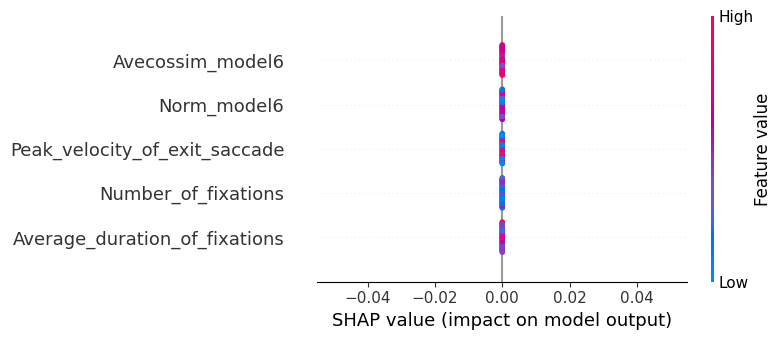

100%|██████████| 52/52 [00:00<00:00, 58.56it/s]


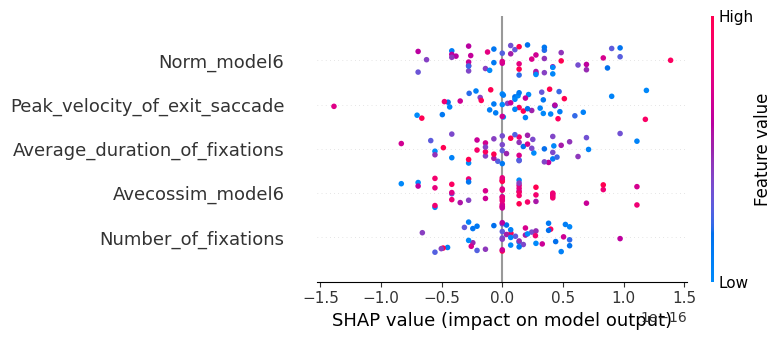

100%|██████████| 52/52 [00:00<00:00, 54.47it/s]


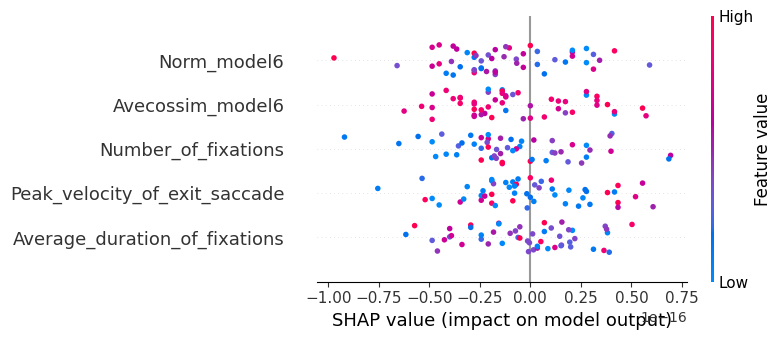

100%|██████████| 52/52 [00:00<00:00, 70.16it/s]


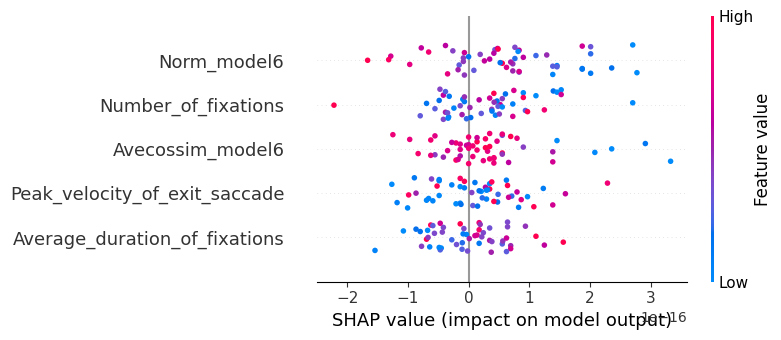

100%|██████████| 52/52 [00:00<00:00, 77.89it/s]


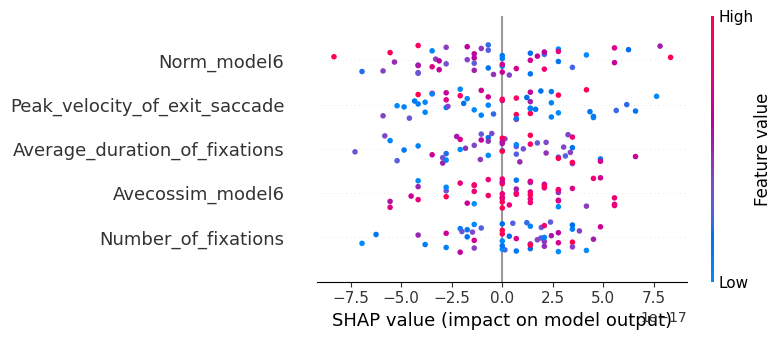

100%|██████████| 52/52 [00:00<00:00, 89.02it/s]


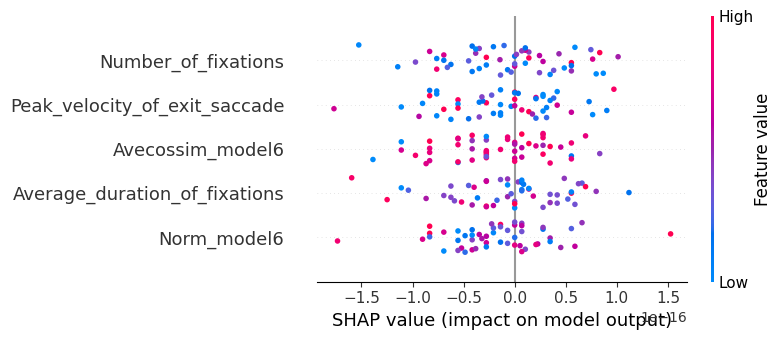

Model log
  Average_duration_of_fixations: -1.2020049085344102e-17
  Number_of_fixations: -1.81603863891322e-17
  Peak_velocity_of_exit_saccade: -1.6317242695906842e-17
  Norm_model6: -1.6529913122048228e-17
  Avecossim_model6: -2.288500585615557e-17
Model rf
  Average_duration_of_fixations: 0.0
  Number_of_fixations: 0.0
  Peak_velocity_of_exit_saccade: 0.0
  Norm_model6: 0.0
  Avecossim_model6: 0.0
Model gb
  Average_duration_of_fixations: 9.570169176362434e-18
  Number_of_fixations: 7.497675023572835e-18
  Peak_velocity_of_exit_saccade: 1.0333280705458e-17
  Norm_model6: 1.5612511283791264e-17
  Avecossim_model6: 1.6012832085939759e-18
Model svm
  Average_duration_of_fixations: -2.7874388275576467e-18
  Number_of_fixations: -8.075221180839151e-18
  Peak_velocity_of_exit_saccade: -1.0758621557740775e-18
  Norm_model6: -1.3014596078181766e-17
  Avecossim_model6: -7.222454472095745e-18
Model knn
  Average_duration_of_fixations: -1.0021051329823953e-18
  Number_of_fixations: 2.788901588

In [20]:


SHAPs = {}
for name, model in random_search.best_estimator_.estimators:
    explainer = shap.KernelExplainer(model.predict_proba, X_train_scaled)
    shap_values = explainer.shap_values(X_train_scaled)
    shap_importances = np.mean(shap_values, axis=(0, 2))
    shaps = {X_train.columns[i]: shap_importances[i] for i in range(len(X_train.columns))}
    # SHAPs[f'{name}'] = np.mean(shap_values, axis=(0, 2))
    shap.summary_plot(np.mean(shap_values, axis=2), X_train_scaled, feature_names=selected_features)
    SHAPs[f'{name}'] = shaps

# 結果を表示
for model_name, importances in SHAPs.items():
    print(f"Model {model_name}")
    for feature, importance in importances.items():
        print(f"  {feature}: {importance}")




In [21]:
# # グラフプロット用の関数
# def plot_feature_importance(Model):
#     for model_name, features in Model.items():
#         plt.figure(figsize=(10, 6))
#         names, values = zip(*sorted(features.items(), key=lambda x: x[1], reverse=True))
#         plt.barh(names, values, color='skyblue')
#         plt.title(f"Feature Importance for Model: {model_name}")
#         plt.xlabel("Permutation Importance")
#         plt.ylabel("Features")
#         plt.tight_layout()
#         plt.show()

# # グラフ描画
# plot_feature_importance(PFIs)


In [22]:
# # 結果の記録
# basemodel_names = [name for name, _ in base_models]

# import datetime
# currenttime = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# """ Accuracy = accuracy_score(y_test, y_pred)
# Precision = precision_score(y_test, y_pred, average='weighted')
# Recall = recall_score(y_test, y_pred, average='weighted')
# F1_Score = f1_score(y_test, y_pred, average='weighted') """

# model_list = random_search.best_estimator_.estimators
# Models = {}
# for name, _ in model_list:
#     Models[f"{name}"] = f"{name}"



# result = {'Original Data shape': [X.shape],
#             'sfs_model' : [sfs_model],
#             'Models': [basemodel_names],
#             'Best number of features': len(sfs.k_feature_idx_),
#             'Slected Features': [selected_features],
#             'Model Params':[random_search.best_params_],
#             'Accuracy': accuracy_score(y_test, y_pred),
#             'Precision': precision_score(y_test, y_pred, average='weighted'),
#             'Recall': recall_score(y_test, y_pred, average='weighted'),
#             'F1_Score' : f1_score(y_test, y_pred, average='weighted'),
#             'Date': currenttime,
#             'Dataset' : file_path
#             }

# save_importances = {
#                     'model' : Models,
#                     'PFI' : PFIs,
#                     # 'SHAP' : SHAPs,
#                     'Date': currenttime
#                     }

# new_result = pd.DataFrame(result)
# new_result.to_csv('C:/WorkSpace/Practice/卒研B/result2.csv',
#                   mode='a',
#                   header=False,
#                   index=False)

# new_importances = pd.DataFrame(save_importances)
# new_importances.to_csv('C:/WorkSpace/Practice/卒研B/importances.csv',
#                   mode='a',
#                   header=True,
#                   index=False)

In [ ]:
# 結果の記録
basemodel_names = [name for name, _ in base_models]

import datetime
currenttime = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

""" Accuracy = accuracy_score(y_test, y_pred)
Precision = precision_score(y_test, y_pred, average='weighted')
Recall = recall_score(y_test, y_pred, average='weighted')
F1_Score = f1_score(y_test, y_pred, average='weighted') """

model_list = random_search.best_estimator_.estimators
Models = {}
for name, _ in model_list:
    Models[f"{name}"] = f"{name}"



result = {'Original Data shape': [X.shape],
            'sfs' : sfs,
            'Models': [basemodel_names],
            'Best number of features': len(selected_features),
            'Slected Features': [selected_features],
            'Model Params':[random_search.best_params_],
            'Model Accuravy':[Model_accuracy],
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, average='weighted'),
            'Recall': recall_score(y_test, y_pred, average='weighted'),
            'F1_Score' : f1_score(y_test, y_pred, average='weighted'),
            'Date': currenttime,
            'Dataset' : file_path
            }

save_importances = {
                    'model' : Models,
                    'PFI' : PFIs,
                    'SHAP' : SHAPs,
                    'Date': currenttime
                    }

new_result = pd.DataFrame(result)
new_result.to_csv('C:/WorkSpace/Practice/卒研B/result4.csv',
                  mode='a',
                  header=False,
                  index=False)

new_importances = pd.DataFrame(save_importances)
new_importances.to_csv('C:/WorkSpace/Practice/卒研B/importances4.csv',
                  mode='a',
                  header=True,
                  index=False)

In [24]:
random_search.best_estimator_.estimators

[('log', LogisticRegression(C=2, max_iter=70, random_state=42, solver='sag')),
 ('rf',
  RandomForestClassifier(criterion='entropy', max_depth=22,
                         min_samples_leaf=0.5568596409751262, n_estimators=62,
                         random_state=42)),
 ('gb',
  GradientBoostingClassifier(learning_rate=0.1443020276231255, max_depth=8,
                             n_estimators=129, random_state=42,
                             subsample=0.8019167000775018)),
 ('svm',
  SVC(C=45.869794351383995, gamma=0.01, probability=True, random_state=42)),
 ('knn', KNeighborsClassifier(leaf_size=43, n_neighbors=6)),
 ('mlp',
  MLPClassifier(alpha=0.0008623921797356448, hidden_layer_sizes=(50,),
                max_iter=161, random_state=42)),
 ('nb', GaussianNB(var_smoothing=5e-09))]

In [25]:
import time
for i in range(5):
    print(i)
    time.sleep(1)
!rundll32 user32.dll,MessageBeep

0
1
2
3
4


In [26]:
shap.plots.waterfall(shap_values[0], max_display=14)

TypeError: The waterfall plot requires an `Explanation` object as the `shap_values` argument.

In [39]:
explainer0 = shap.Explainer(random_search.best_estimator_.predict, X_train_scaled)
shap_values0 = explainer0(X_slected)

ExactExplainer explainer: 539it [13:43,  1.55s/it]                         


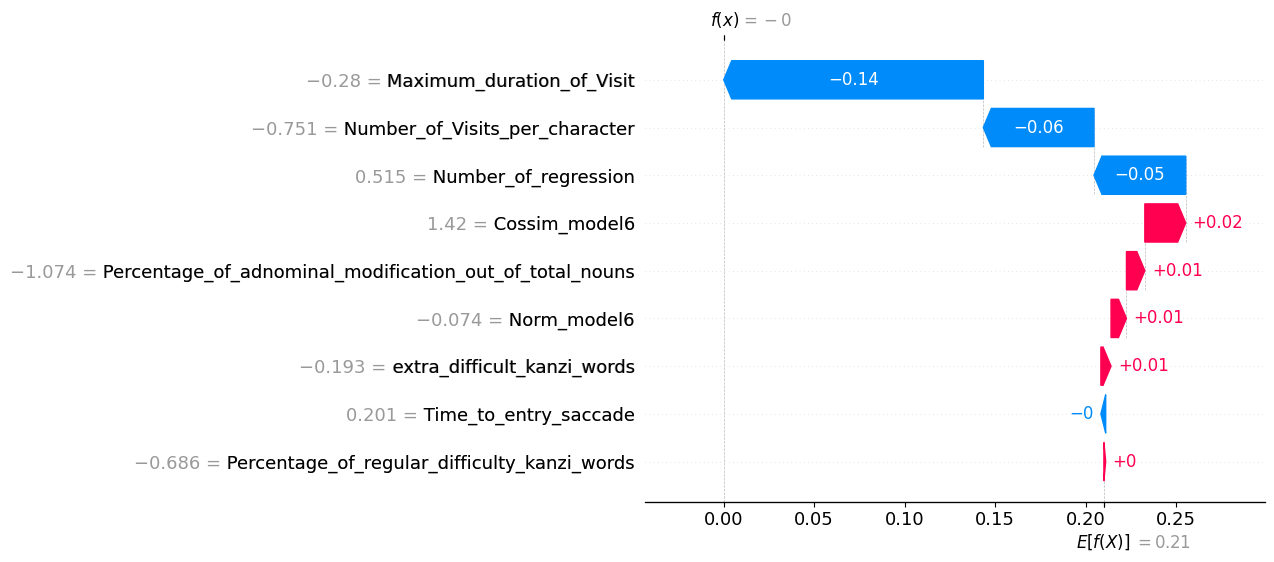

In [30]:
shap.plots.waterfall(shap_values0[10], max_display=14, )

In [35]:
random_search.best_estimator_.estimators[4]

('knn', KNeighborsClassifier(leaf_size=28))